<a href="https://github.com/thangckt/note_md/blob/main/notebook/free_energy/mlcvs/1_2d_model_discriminant.ipynb" role="button"><img src="https://img.shields.io/static/v1?label=&amp;message=View%20On%20GitHub&amp;color=586069&amp;logo=github&amp;labelColor=2f363d"></a> &nbsp;
<a href="https://colab.research.google.com/github/thangckt/note_md/blob/main/notebook/free_energy/mlcvs/1_2d_model_discriminant.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a> &nbsp;
<a target="_blank" href="https://thangckt.github.io/note_md/notebook/free_energy/mlcvs/1_2d_model_discriminant"><img src="https://img.shields.io/badge/📖 Read-blog post-9cf"></a>

# LDA & Deep-LDA - Toy model

Data-driven collective variables built upon Fisher's discriminant analysis, both in its linear and non-linear version.

**System**: Wolfe-Quapp 2D potential (rotated)

# Overview


In [1]:
import torch

import numpy as np
import pandas as pd

from thatool.io  import read_data
from thatool.vis import matplot_style
import matplotlib.pyplot as plt
plt.style.use(matplot_style.light)

dir_nb = globals()['_dh'][0]

# Data


Download data from repo: https://github.com/luigibonati/mlcvs/blob/main/docs/notebooks/data

In [2]:
import requests

# Download data from GitHub to this notebook's local drive
files = ['data/2d_model/COLVAR_stateA', 'data/2d_model/COLVAR_stateB']
for file in files:
    url = "https://raw.githubusercontent.com/luigibonati/mlcvs/main/docs/notebooks/" + file
    r = requests.get(url)
    with open(file, 'wb') as f:
        f.write(r.content)

## Load data

In [3]:
# Load colvar files as pandas dataframes
dataA = read_data.matrix_auto("data/2d_model/COLVAR_stateA", column_line=0)
dataB = read_data.matrix_auto("data/2d_model/COLVAR_stateB", column_line=0)

# Create input datasets
xA = dataA.filter(regex="p.*").values
xB = dataB.filter(regex="p.*").values
names = dataA.filter(regex="p.*").columns.values

# Create labels
yA = np.zeros(len(dataA))
yB = np.ones(len(dataB))

# Concatenate
X = np.concatenate([xA, xB], axis=0)
y = np.concatenate([yA, yB], axis=0)

# Shuffle
np.random.seed(1)
p = np.random.permutation(len(X))
X, y = X[p], y[p]

# Convert np to torch.Tensors
X = torch.Tensor(X)
y = torch.Tensor(y)

## plot states

In [4]:
dataA

,time,p.x,p.y
0,0.0,-1.750000,0.750000
1,2.5,-1.254682,1.558291
2,5.0,-1.952951,0.874572
3,7.5,-1.959987,0.599997
4,10.0,-2.056896,0.609804
...,...,...,...
496,1240.0,-1.596924,0.608113
497,1242.5,-2.128538,0.907752
498,1245.0,-1.966120,0.736077
499,1247.5,-1.909419,0.787014


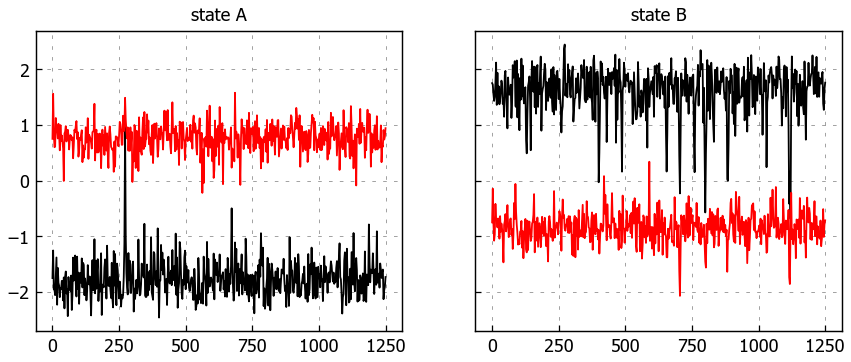

In [5]:
## plot
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8,3), sharey=True)
axs[0].plot(dataA['time'], dataA.filter(regex='p'))   # plot p.*
axs[1].plot(dataB['time'], dataB.filter(regex='p'))   # plot p.*
axs[0].set_title('state A')
axs[1].set_title('state B')
plt.show()

Plotting functions

In [6]:
def plot_isolines_grid(cv,limits=((-3,3),(-3,3)),num_points=(50,50),scatter=None,ax=None):

    if type(num_points) == int:
        num_points = (num_points,num_points)

    # Define grid and evaluate cv on it
    xx = np.linspace(limits[0][0],limits[0][1],num_points[0])
    yy = np.linspace(limits[1][0],limits[1][1],num_points[1])
    xv, yv = np.meshgrid(xx, yy, indexing='xy')
    z = np.zeros_like(xv)
    for i in range(num_points[0]):
        for j in range(num_points[1]):
            xy = torch.Tensor([xv[i,j], yv[i,j]])
            z[i,j] = cv(xy)

    # Setup plot
    if ax is None:
        _, ax = plt.subplots(figsize=(5,4.), dpi=100)
        ax.set_title(f'{cv.name_} isolines')

    # Plot countour plot
    h = ax.contourf(xx, yy, z)
    cbar = plt.colorbar(h,ax=ax)
    cbar.set_label(f'{cv.name_}')

    # Scatter plot with training data
    if scatter is not None:
        ax.scatter(scatter[:,0],scatter[:,1],s=2,c='white',alpha=0.5)
        ax.set_aspect('equal') 

def plot_cv_histogram(s,label=None,ax=None,**kwargs):
    # Setup plot
    if ax is None:
        _, ax = plt.subplots(figsize=(5,4.), dpi=100)
        ax.set_title('Histogram')

    if (type(s)==torch.Tensor):
        s = s.squeeze(1).detach().numpy()

    # Plot histogram
    ax.hist(s,**kwargs)
    if label is not None:
        ax.set_xlabel(label)


# HLDA: Harmonic Linear Discriminant Analysis

Reference: _Mendels, Piccini, Parrinello, JCPL 2018_.

## Data

X, y from previous cell

In [7]:
n_features = X.shape[1]
feature_names = names

## Train CV

In [8]:
from mlcvs.lda import LDA_CV

hlda = LDA_CV(n_features=n_features, harmonic_lda=True)

hlda.fit(X, y)

c:\DevProgram\miniconda3\envs\py39mlcvs\lib\site-packages\mlcvs\lda\lda.py:118: UserWarning: torch.cholesky is deprecated in favor of torch.linalg.cholesky and will be removed in a future PyTorch release.
L = torch.cholesky(A)
should be replaced with
L = torch.linalg.cholesky(A)
and
U = torch.cholesky(A, upper=True)
should be replaced with
U = torch.linalg.cholesky(A).mH().
This transform will produce equivalent results for all valid (symmetric positive definite) inputs. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\BatchLinearAlgebra.cpp:1626.)
  L = torch.cholesky(S_w, upper=False)
c:\DevProgram\miniconda3\envs\py39mlcvs\lib\site-packages\mlcvs\lda\lda.py:127: UserWarning: torch.symeig is deprecated in favor of torch.linalg.eigh and will be removed in a future PyTorch release.
The default behavior has changed from using the upper triangular portion of the matrix by default to using the lower triangular portion.
L, _ = torch.symeig(A, upper=upper)
shou

## Plot results

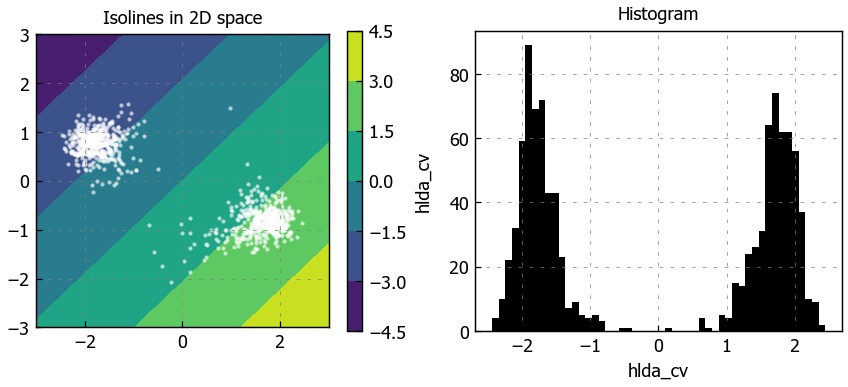

In [9]:
_, axs = plt.subplots(1,2, figsize=(8,3), dpi=130)

# CV isolines
axs[0].set_title(f'Isolines in 2D space')
plot_isolines_grid(hlda, scatter=X, num_points=50, ax=axs[0])

# Calculate CV values over training set
axs[1].set_title(f'Histogram')
s = hlda(X)
plot_cv_histogram(s,label=hlda.name_,bins=50, ax=axs[1] )

## Get PLUMED input

In [10]:
hlda.set_params({"feature_names": feature_names})
print( hlda.plumed_input() )

hlda_cv: CUSTOM ARG=p.x,p.y VAR=x0,x1 FUNC=0.689055*x0-0.724709*x1 PERIODIC=NO



# Deep-LDA: Neural network-based discriminant analysis

Reference: _Bonati, Rizzi, Parrinello, JCPL 2020_.

## Data

X, y from previous cell

In [11]:
n_features = X.shape[1]
feature_names = names

# split train/test
ntrain,nvalid = 800,200

# ... replace with dataloder from file

## Train CV

In [12]:
from mlcvs.lda import DeepLDA_CV

#------------- PARAMETERS -------------
nodes             = [n_features,30,30,5]

lrate             = 0.001
sw_reg            = 0.05
l2_reg            = 1e-5

num_epochs        = 1000
earlystop         = True
es_patience       = 20
es_consecutive    = False
es_min_delta      = 0.05

log_every         = 100
#--------------------------------------

# DEVICE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# MODEL
model = DeepLDA_CV(nodes)
model.set_device(device)

# REGULARIZATION
model.set_regularization(sw_reg=sw_reg)
model.set_earlystopping(patience=es_patience,consecutive=es_consecutive,min_delta=es_min_delta)

# TRAIN
model.fit(X=X,y=y, standardize_inputs = True, log_every=log_every)

# standardize outputs
#model.standardize_outputs(train_data[0].to(device))

Created dataloaders
Training   set: 801
Validation set: 201
epoch           loss_train      loss_valid      
100             -48.320 -47.649 
INFO: Early stopping
184             -60.583 -58.717 


In [13]:
# get back to CPU
model.to('cpu')

DeepLDA_CV(
  (nn): Sequential(
    (0): Linear(in_features=2, out_features=30, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=30, out_features=30, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=30, out_features=5, bias=True)
  )
)

## Plot learning curve

c:\DevProgram\miniconda3\envs\py39mlcvs\lib\site-packages\numpy\core\shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
c:\DevProgram\miniconda3\envs\py39mlcvs\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


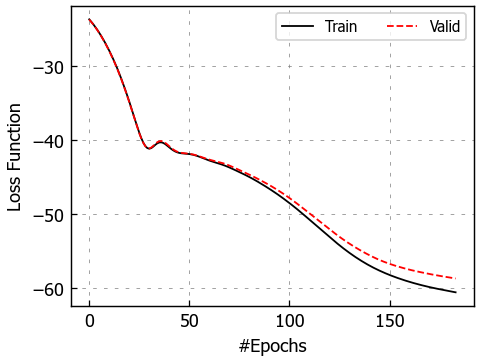

In [14]:
loss_train = model.logs['loss_train']
loss_valid = model.logs['loss_valid']

# Plot Loss function
fig, ax = plt.subplots(figsize=(4,3),dpi=130)
ax.plot(loss_train,'-',label='Train')
ax.plot(loss_valid,'--',label='Valid')
ax.set_ylabel('Loss Function')
ax.set_xlabel('#Epochs')
ax.legend(ncol=2)

# if model.earlystopping_.early_stop:
#    ax.axvline(model.earlystopping_.best_epoch,ls='dotted',c='grey',label='Early Stopping')

plt.show()

## Plot results

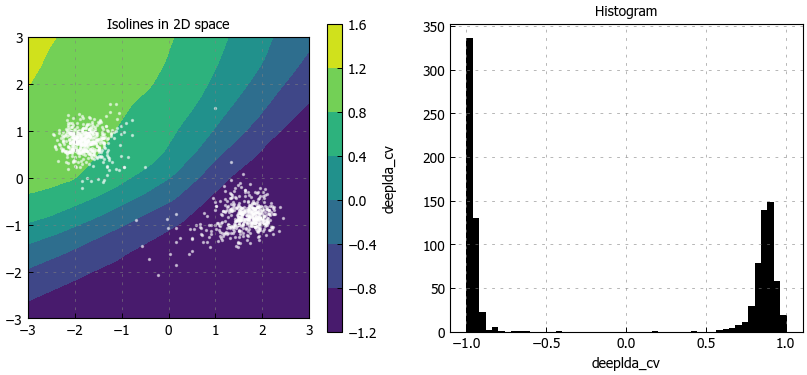

In [15]:
_, axs = plt.subplots(1,2, figsize=(10,4.), dpi=100)

# CV isolines
axs[0].set_title(f'Isolines in 2D space')
plot_isolines_grid(model, scatter=X, num_points=50, ax=axs[0])

# Calculate CV values over training set
axs[1].set_title(f'Histogram')
s = model(X)
plot_cv_histogram(s,label=model.name_,bins=50, ax=axs[1] )